In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline


if not os.path.isdir('model'):
    os.makedirs('model')

print ('Tensorflow version: ',tf.__version__)

Tensorflow version:  2.19.0


In [2]:
def get_ten_classes(x,y):
  indices_0, _ =np.where(y==0.)
  indices_1, _ =np.where(y==1.)
  indices_2, _ =np.where(y==2.)
  indices_3, _ =np.where(y==3.)
  indices_4, _ =np.where(y==4.)
  indices_5, _ =np.where(y==5.)
  indices_6, _ =np.where(y==6.)
  indices_7, _ =np.where(y==7.)
  indices_8, _ =np.where(y==8.)
  indices_9, _ =np.where(y==9.)

  indices=np.concatenate([indices_0,indices_1,indices_2,indices_3,indices_4,indices_5,indices_6,indices_7,indices_8,indices_9],axis=0)

  x=x[indices]
  y=y[indices]

  count=x.shape[0]
  indices = np.random.choice(range(count),count,replace=False)
  x=x[indices]
  y=y[indices]

  y=tf.keras.utils.to_categorical(y)
  return x,y

(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()
x_train,y_train=get_ten_classes(x_train,y_train)
x_test,y_test=get_ten_classes(x_test,y_test)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


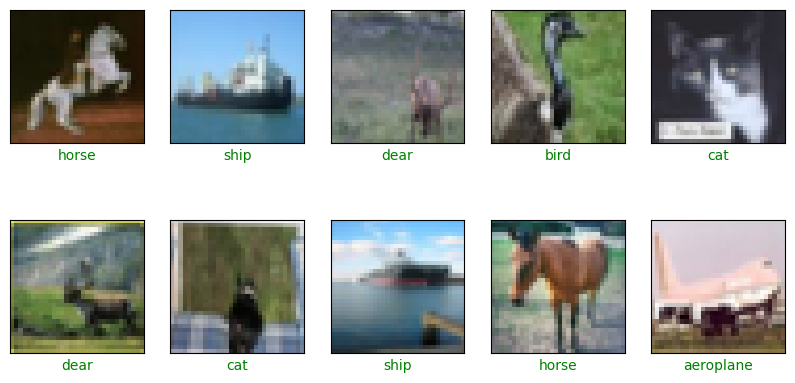

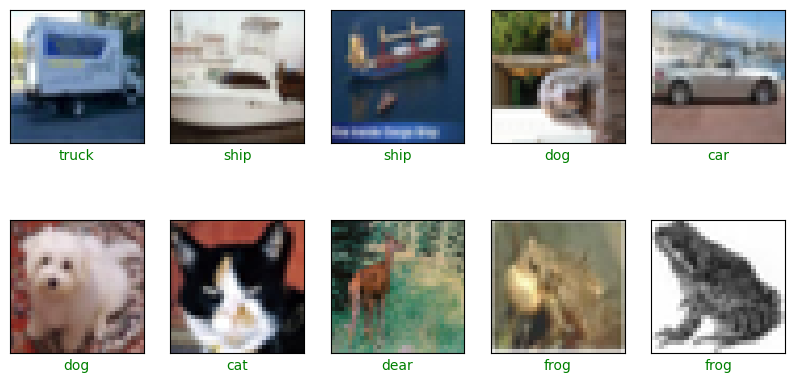

In [3]:
class_names=['aeroplane','car','bird','cat','dear','dog','frog','horse','ship','truck']

def show_random_examples(x,y,p):
  indices=np.random.choice(range(x.shape[0]),10,replace=False)

  x=x[indices]
  y=y[indices]
  p=p[indices]

  plt.figure(figsize=(10,5))
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])

    col='green' if np.argmax(y[i])==np.argmax(p[i]) else 'red'
    plt.xlabel(class_names[np.argmax(p[i])],color=col)

plt.show()

show_random_examples(x_train,y_train,y_train)
show_random_examples(x_test,y_test,y_test)


In [4]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Input


def create_model():
  def add_conv_block(model,num_filters):
    model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(num_filters, 3, activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.5))
    return model

  model = tf.keras.models.Sequential()
  model.add(Input(shape=(32, 32, 3)))

  model = add_conv_block(model, 32)
  model = add_conv_block(model, 64)
  model = add_conv_block(model, 128)

  model.add(Flatten())
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = create_model()
# model.summary()

In [ ]:
h=model.fit(
    x_train/255.,y_train,
    validation_data=(x_test/255.,y_test),
    epochs=10,batch_size=256,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',save_best_only=True,
                                           save_weights_only=False,monitor='val_accuracy')
    ]
)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2596 - loss: 2.4129

196/196 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.2600 - loss: 2.4105 - val_accuracy: 0.1150 - val_loss: 3.3596
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4557 - loss: 1.5013

196/196 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.4558 - loss: 1.5011 - val_accuracy: 0.1376 - val_loss: 3.9596
Epoch 3/10
 15/196 ━━━━━━━━━━━━━━━━━━━━ 5:06 2s/step - accuracy: 0.4989 - loss: 1.3804

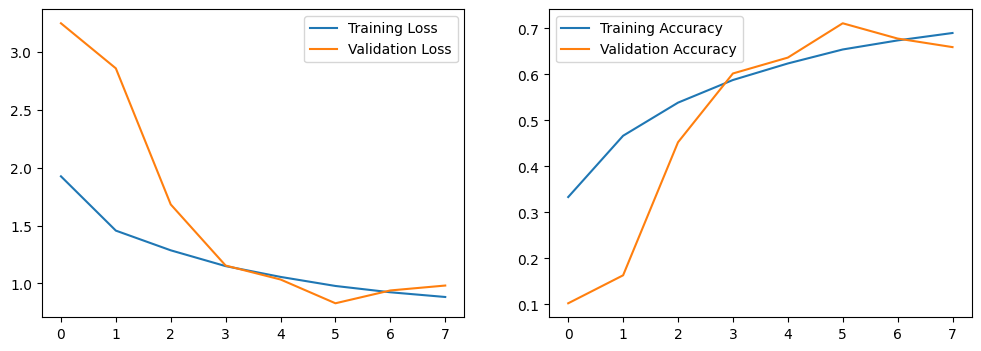

In [ ]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('models/model_0.732.h5')
preds = model.predict(x_test/255.)

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step


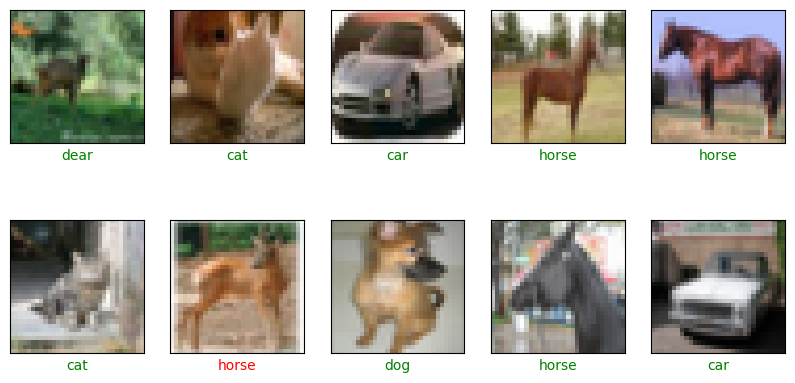

In [ ]:
show_random_examples(x_test, y_test, preds)

In [2]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to preprocess a single image
def preprocess_single_image(image_path):
    img = Image.open(image_path)
    img = img.resize((32, 32))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# Function to predict and display the image with prediction
def predict_single_image(model, image_path, class_names):
    processed_image = preprocess_single_image(image_path)
    predictions = model.predict(processed_image)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted: {predicted_class_name}")
    plt.show()


# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python/train/automobile/0001.png -O car_example.png
predict_single_image(model, 'sample/airplane.jpg', class_names)

NameError: name 'model' is not defined

In [ ]:
%%writefile app.py
import streamlit as st
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import io

MODEL_PATH = 'models/model_0.732.h5'
model = load_model(MODEL_PATH)


class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

st.title('Image Classification App')
st.write('Upload an image and the model will predict its class.')

uploaded_file = st.file_uploader('Choose an image...', type=['jpg', 'jpeg', 'png'])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    st.write('')
    st.write('Classifying...')

    img = image.resize((32, 32))
    img_array = np.array(img)
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    st.write(f'Prediction: **{predicted_class}**')
